# Model Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')

In [0]:
#all edits from Tuesday aka today
df = df.select_dtypes(np.number)

df = df.rename(columns = {'GrLivArea':'insidesqrft', 'GarageArea':'garagesqrft', 
                          'TotalBsmtSF':'basementsqrft', 'LotArea':'lotsqrft', 'BedroomAbvGr':'bedrooms',
                          'TotRmsAbvGrd':'totalrooms'})

df['bathrooms'] = df.FullBath + (df.HalfBath/2) #1
df['has_fireplace'] = df.Fireplaces != 0 #2
df['has_fireplace'] = df.has_fireplace.astype(int)
df['haspool'] = df.PoolArea != 0 #3
df['haspool'] = df.haspool.astype(int)
df['decksqrft'] = df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + df['3SsnPorch'] + df.ScreenPorch #4
df['hasdeck'] = df.decksqrft != 0 #5
df['hasdeck'] = df.hasdeck.astype(int)
df['years_since_major_model'] = 2010 - df.YearRemodAdd #6
df['sqrft_per_room'] = df.insidesqrft / df.totalrooms #7
df['total_sqrft'] = df.insidesqrft + df.decksqrft + df.garagesqrft + df.lotsqrft #8
df['total_building_sqrft'] = df.insidesqrft + df.decksqrft + df.garagesqrft #9
df['years_since_major_model_when_bought'] = df.YrSold - df.YearRemodAdd #10

#polynomial features
df['years_squared'] = df.years_since_major_model ** 2
df['lotsqrft_squared'] = df.lotsqrft ** 2
df['insidesqrft_squared'] = df.lotsqrft ** 2
df['decksqrft_squared'] = df.decksqrft **2
df['garagesqrft_squared'] = df.garagesqrft ** 2
df['total_sqrft_squared'] = df.total_sqrft ** 2
df['total_building_sqrft_squared'] = df.total_building_sqrft ** 2
df['sqrft_per_room_squared'] = df.sqrft_per_room ** 2

#interaction feature
df['interaction_inside'] = df.insidesqrft * df.sqrft_per_room
df['interaction_inside_squared'] = df.insidesqrft_squared * df.sqrft_per_room_squared

df = df.drop(columns = ['GarageYrBlt', 'LotFrontage', 'MasVnrArea'])
df = df.drop(columns = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                        'KitchenAbvGr', 'Fireplaces', 'GarageCars'])
df = df.drop(columns = ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF',
                        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                        'ScreenPorch', 'PoolArea', 'MiscVal', '1stFlrSF',
                        '2ndFlrSF'])
df = df.drop(columns = ['YearBuilt', 'YearRemodAdd', 'MSSubClass', 'Id'])

In [103]:
df.shape

(1460, 31)

In [104]:
pd.set_option('display.max_columns', 100)
df.describe()

,lotsqrft,OverallQual,OverallCond,basementsqrft,insidesqrft,bedrooms,totalrooms,garagesqrft,MoSold,YrSold,SalePrice,bathrooms,has_fireplace,haspool,decksqrft,hasdeck,years_since_major_model,sqrft_per_room,total_sqrft,total_building_sqrft,years_since_major_model_when_bought,years_squared,lotsqrft_squared,insidesqrft_squared,decksqrft_squared,garagesqrft_squared,total_sqrft_squared,total_building_sqrft_squared,sqrft_per_room_squared,interaction_inside,interaction_inside_squared
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1460.000000,1.460000e+03,1.460000e+03
mean,10516.828082,6.099315,5.575342,1057.429452,1515.463699,2.866438,6.517808,472.980137,6.321918,2007.815753,180921.195890,1.756507,0.527397,0.004795,181.329452,0.826027,25.134247,230.905362,12686.60137,2169.773288,22.950000,1057.671233,2.101611e+08,2.101611e+08,5.740469e+04,2.693914e+05,2.651454e+08,5.239441e+06,55317.618097,3.652896e+05,1.499677e+13
std,9981.264932,1.382997,1.112799,438.705324,525.480383,0.815778,1.625393,213.804841,2.703626,1.328095,79442.502883,0.636015,0.499420,0.069100,156.656097,0.379216,20.645407,44.740397,10211.11761,729.307363,20.640653,1286.124639,1.607110e+09,1.607110e+09,9.250344e+04,2.242881e+05,1.658055e+09,3.885872e+06,22558.847545,1.957317e+05,1.233322e+14
min,1300.000000,1.000000,1.000000,0.000000,334.000000,0.000000,2.000000,0.000000,1.000000,2006.000000,34900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,2163.00000,334.000000,-1.000000,0.000000,1.690000e+06,1.690000e+06,0.000000e+00,0.000000e+00,4.678569e+06,1.115560e+05,14400.000000,5.577800e+04,8.545098e+10
25%,7553.500000,5.000000,5.000000,795.750000,1129.500000,2.000000,5.000000,334.500000,5.000000,2007.000000,129975.000000,1.000000,0.000000,0.000000,45.000000,1.000000,6.000000,199.000000,9392.50000,1664.750000,4.000000,36.000000,5.705542e+07,5.705542e+07,2.025000e+03,1.118970e+05,8.821908e+07,2.771393e+06,39601.000000,2.324493e+05,2.387772e+12
50%,9478.500000,6.000000,5.000000,991.500000,1464.000000,3.000000,6.000000,480.000000,6.000000,2008.000000,163000.000000,2.000000,1.000000,0.000000,164.000000,1.000000,16.000000,226.500000,11543.00000,2075.000000,14.000000,256.000000,8.984196e+07,8.984196e+07,2.689600e+04,2.304000e+05,1.332409e+08,4.305625e+06,51302.250000,3.329280e+05,4.380371e+12
75%,11601.500000,7.000000,6.000000,1298.250000,1776.750000,3.000000,7.000000,576.000000,8.000000,2009.000000,214000.000000,2.500000,1.000000,0.000000,266.000000,1.000000,43.000000,256.107143,14124.00000,2572.500000,41.000000,1849.000000,1.345948e+08,1.345948e+08,7.075600e+04,3.317760e+05,1.994874e+08,6.617757e+06,65590.903061,4.508356e+05,7.717160e+12
max,215245.000000,10.000000,9.000000,6110.000000,5642.000000,8.000000,14.000000,1418.000000,12.000000,2010.000000,755000.000000,3.500000,1.000000,1.000000,1027.000000,1.000000,60.000000,470.166667,217794.00000,7566.000000,60.000000,3600.000000,4.633041e+10,4.633041e+10,1.054729e+06,2.010724e+06,4.743423e+10,5.724436e+07,221056.694444,2.652680e+06,3.000832e+15


## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

In [0]:
goodplots = []

# Squared Squarefoot

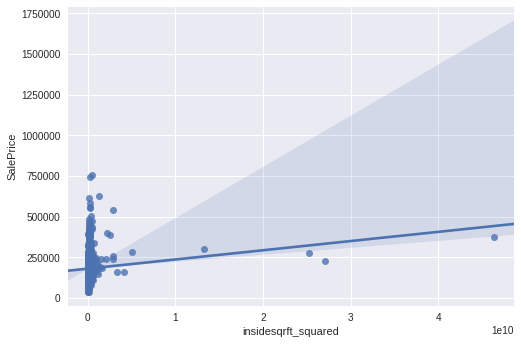

In [106]:
fig = sns.regplot(df.insidesqrft_squared, df.SalePrice)

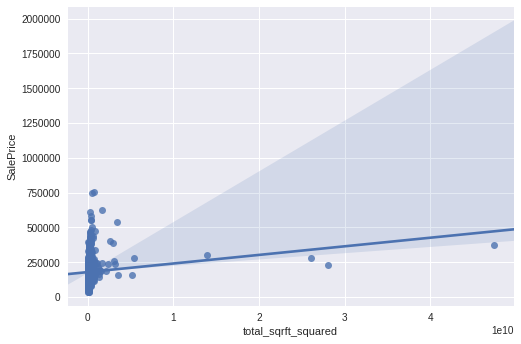

In [107]:
fig = sns.regplot(df.total_sqrft_squared, df.SalePrice)
#extremely unhelpful

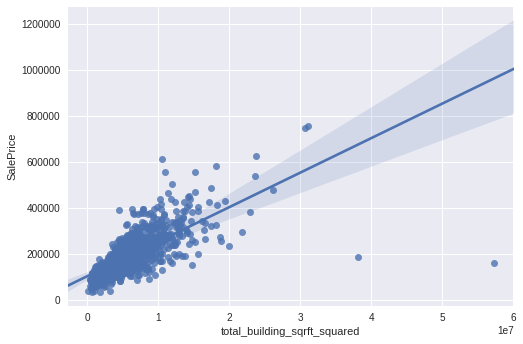

In [108]:
import seaborn as sns
fig = sns.regplot(df.total_building_sqrft_squared,df.SalePrice)
goodplots.append('total_building_sqrft_squared')
goodplots.append('total_building_sqrft')

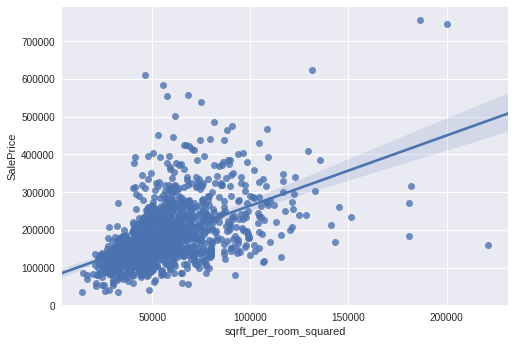

In [109]:
fig = sns.regplot(df.sqrft_per_room_squared,df.SalePrice)
#not useful

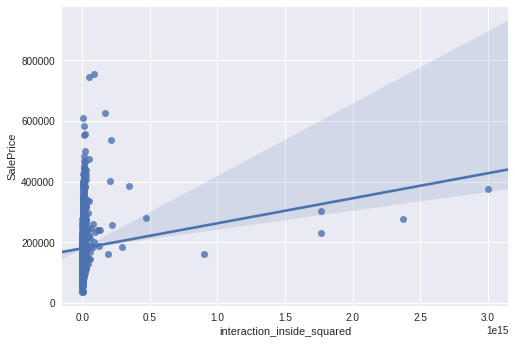

In [110]:
fig = sns.regplot(df.interaction_inside_squared,df.SalePrice)
#not helpful

# House Age

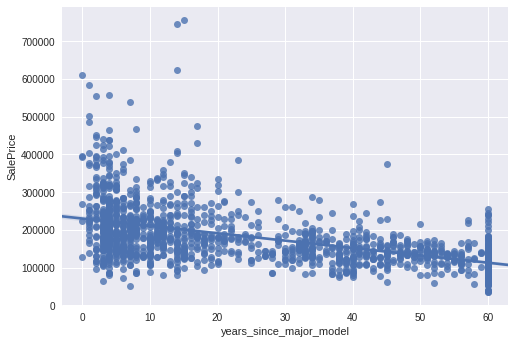

In [111]:
fig2 = sns.regplot(df.years_since_major_model, df.SalePrice)
goodplots.append('years_since_major_model')

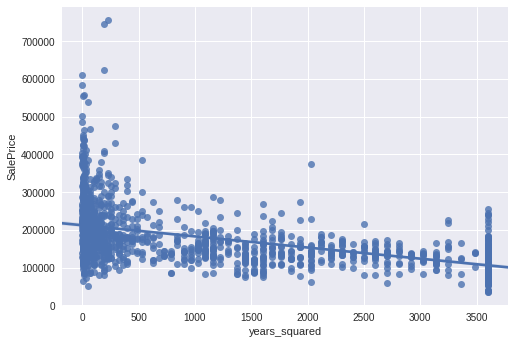

In [112]:
fig = sns.regplot(df.years_squared, df.SalePrice)
goodplots.append('years_squared')

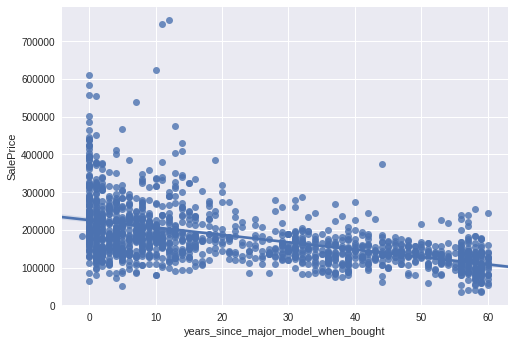

In [113]:
fig = sns.regplot(df.years_since_major_model_when_bought, df.SalePrice)
goodplots.append('years_since_major_model_when_bought')

# Integers

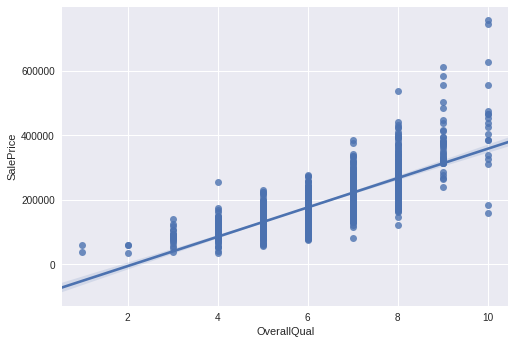

In [114]:
fig3 = sns.regplot(df.OverallQual, df.SalePrice)
goodplots.append('OverallQual')

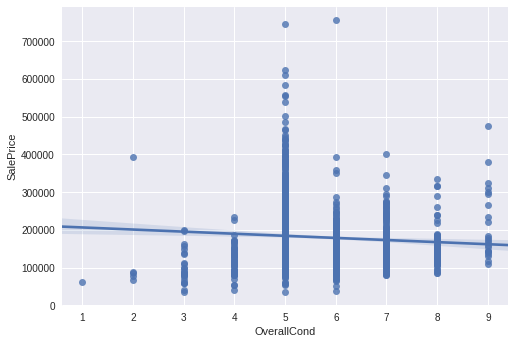

In [115]:
sns.regplot(df.OverallCond, df.SalePrice)

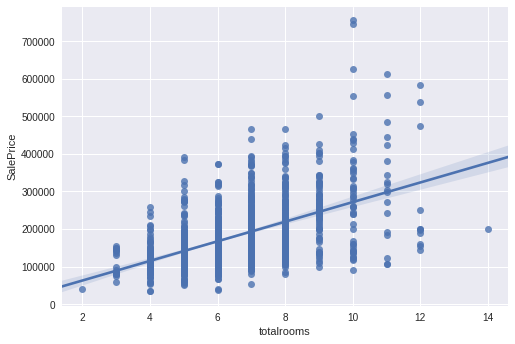

In [116]:
sns.regplot(df.totalrooms, df.SalePrice)
goodplots.append('totalrooms')

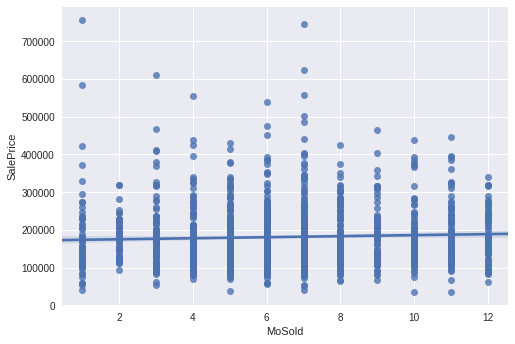

In [117]:
sns.regplot(df.MoSold, df.SalePrice)

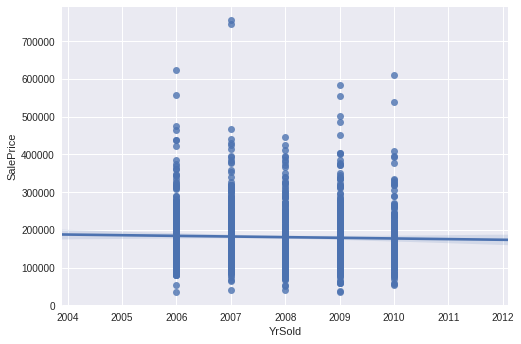

In [118]:
sns.regplot(df.YrSold, df.SalePrice)

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

In [0]:
import statsmodels.api as sm
X = df[goodplots]
X = sm.add_constant(X) #eqivalent to numpy.ones
y = df['SalePrice']

In [120]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())
#low t - total_building_sqrft_squared, years_since_major_model,
         #years_since_major_model_when_bought
#JB, condition number is high (high multicollinearity)
#poor conf - years_since_major_model, years_since_major_model_when_bought

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     630.8
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        05:23:35   Log-Likelihood:                -17525.
No. Observations:                1460   AIC:                         3.507e+04
Df Residuals:                    1452   BIC:                         3.511e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

poor standard errors: years_since_major_model , years_since_major_model_when_bought, totalrooms

poor p-values: total_building_sqrft_squared, years_since_major_model,      years_since_major_model_when_bought, totalrooms

likely significant features: total_building_sqrft (less than 0.000), years_squared (0.001)

In this regression the null hypothesis is that a feature's coefficient is close to 0, or irrelevant to the relationship in y. A high p value does not reject this hypothesis. A reliably relevant feature will have a p value less than 0.05.

## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [121]:
for label, col in df.iteritems():
  Q1 = col.quantile(0.25)
  Q3 = col.quantile(0.75)
  IQR = Q3 - Q1
  df = df[((Q1 -(IQR*1.5)) <= col) & (col <= (Q3 +(IQR*1.5)))]
  
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,lotsqrft,OverallQual,OverallCond,basementsqrft,insidesqrft,bedrooms,totalrooms,garagesqrft,MoSold,YrSold,SalePrice,bathrooms,has_fireplace,haspool,decksqrft,hasdeck,years_since_major_model,sqrft_per_room,total_sqrft,total_building_sqrft,years_since_major_model_when_bought,years_squared,lotsqrft_squared,insidesqrft_squared,decksqrft_squared,garagesqrft_squared,total_sqrft_squared,total_building_sqrft_squared,sqrft_per_room_squared,interaction_inside,interaction_inside_squared
0,8450,7,5,856,1710,3,8,548,2,2008,208500,2.5,0,0,61,1,7,213.750000,10769,2319,5,49,71402500,71402500,3721,300304,115971361,5377761,45689.062500,365512.500000,3.262313e+12
2,11250,7,5,920,1786,3,6,608,9,2008,223500,2.5,1,0,42,1,8,297.666667,13686,2436,6,64,126562500,126562500,1764,369664,187306596,5934096,88605.444444,531632.666667,1.121413e+13
3,9550,7,5,756,1717,3,7,642,2,2006,140000,1.0,1,0,307,1,40,245.285714,12216,2666,36,1600,91202500,91202500,94249,412164,149230656,7107556,60165.081633,421155.571429,5.487206e+12
5,14115,5,5,796,1362,1,5,480,10,2009,143000,1.5,0,0,390,1,15,272.400000,16347,2232,14,225,199233225,199233225,152100,230400,267224409,4981824,74201.760000,371008.800000,1.478346e+13
6,10084,8,5,1686,1694,3,7,636,8,2007,307000,2.0,1,0,312,1,5,242.000000,12726,2642,2,25,101687056,101687056,97344,404496,161951076,6980164,58564.000000,409948.000000,5.955201e+12


In [0]:
X = df[goodplots]
X = sm.add_constant(X)
y = df['SalePrice']

In [124]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())
#low ts - total_building_sqrft, years_since_major_model_when_bought
#JB is good
#poor conf intervals - totalrooms, years_since_major_model,
                      #years_since_major_model_when_bought
#The condition number is large, 7.8e+07. This might indicate that there are
#strong multicollinearity or other numerical problems.

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     433.0
Date:                Fri, 22 Feb 2019   Prob (F-statistic):          2.26e-264
Time:                        05:41:05   Log-Likelihood:                -9073.9
No. Observations:                 792   AIC:                         1.816e+04
Df Residuals:                     784   BIC:                         1.820e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

The most impactful change in coef is on total_building_sqrft, which goes from highly relevant (48) to likely not relevant (0.4). Its square becomes much more likely to be relevant relative to itself (0.0009 to 0.01). years_since_major_model_when_bought flips from a negative coef to similar range positive.

## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

In [0]:
df['SalePrice_log'] = np.log(df.SalePrice)
y = df['SalePrice_log']

In [127]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())
#npw every feature's irrelevant

                            OLS Regression Results                            
Dep. Variable:          SalePrice_log   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     391.6
Date:                Fri, 22 Feb 2019   Prob (F-statistic):          5.88e-251
Time:                        05:54:15   Log-Likelihood:                 414.11
No. Observations:                 792   AIC:                            -812.2
Df Residuals:                     784   BIC:                            -774.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [0]:
##### Your Code Here #####

## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

In [0]:
##### Your Code Here #####

## 2.3 If you have varaibles with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

In [0]:
##### Your Code Here #####

## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [0]:
##### Your Code Here #####

## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

In [0]:
##### Your Code Here #####

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

In [0]:
##### Your Code Here #####

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [0]:
##### Your Code Here #####